# Import data

Based on : "Exploiting Similarities among Languages for Machine Translation" of Tomas Mikolov, Quoc V. Le & Ilya Sutskever (2013)

In [1]:
import io

import numpy as np
from numpy import dot
from numpy.linalg import norm

import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

In [2]:
# load function for pretrained versions of word embeddings
def load_embeddings(emb_path, nmax=50000):
    vectors = []
    word2id = {}
    with io.open(emb_path, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
        next(f)
        for i, line in enumerate(f):
            word, vect = line.rstrip().split(' ', 1)
            vect = np.fromstring(vect, sep=' ')
            assert word not in word2id, 'word found twice'
            vectors.append(vect)
            word2id[word] = len(word2id)
            if len(word2id) == nmax:
                break
    id2word = {v: k for k, v in word2id.items()}
    embeddings = np.vstack(vectors)
    return embeddings, id2word, word2id

In [3]:
eng_path = 'wiki.multi.en.vec' 
fr_path = 'wiki.multi.fr.vec'
nmax = 50000  # maximum number of word embeddings to load

# load monolingual word embeddings 
src_embeddings, src_id2word, src_word2id = load_embeddings(fr_path, nmax) # source = french 
tgt_embeddings, tgt_id2word, tgt_word2id = load_embeddings(eng_path, nmax) # target = english

FRENCH to ENGLISH translation

* source language = french
* target language = english

In [4]:
# load ground-truth bilingual dictionaries function
def load_dic(path):
    dico_full = {}
    vectors_src=[]
    vectors_tgt = []
    with io.open(path,'r',encoding='utf_8') as f:
        for i,line in enumerate(f):
            word_src, word_tgt = line.rstrip().split(' ',1)
            if word_tgt in tgt_word2id :
                dico_full[word_src]=word_tgt
    for key in dico_full.keys() :
            vectors_src.append(src_embeddings[src_word2id[key]])
            vectors_tgt.append(tgt_embeddings[tgt_word2id[dico_full[key]]])
    X = np.vstack(vectors_src)
    Z = np.vstack (vectors_tgt)
    return dico_full,X,Z

In [5]:
# train & test bilingual dictionaries
path_train = r'fr-en.0-5000.txt' 
path_test = r'fr-en.5000-6500.txt'
dico_train, X_train, Z_train = load_dic(path_train)
dico_test, X_test, Z_test = load_dic(path_test) 

In [7]:
# function to minimize 
# normalisation added
def C(W,X,Z):
    S = 0
    S = sum(np.linalg.norm(np.dot(X, W.T) - Z, axis=1)**2) 
    return S

# gradient of the function to minimize
# normalisation added
def GradW(W,X,Z):
    G = np.zeros((Z_train.shape[1], X_train.shape[1]))
    G = 2*np.dot(X.T, (np.dot(X, W.T) - Z)).T
    return G

# GD function
def GradientDescent(eta, niter): 
    W = np.random.rand(300,300) # random initialisation of W
    value_C = np.zeros(niter)
    for t in range(niter): 
        value_C[t] = (1/(X_train.shape[0])) * C(W,X_train,Z_train)
        W -= (1/X_train.shape[0])*eta*GradW(W,X_train,Z_train)
    print("GD done...")
    return (W, value_C) #,acc_test,acc_train)

### Train + test the model
The goal is to find the best W to map the source language to the target one.

GD done...


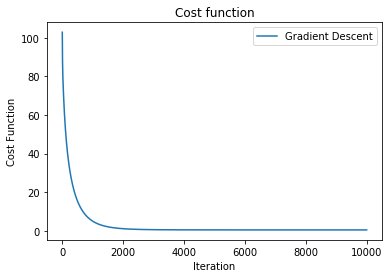

In [220]:
eta = 0.3
niter = 10000
batch_size = 1000

W_GD, C_GD = GradientDescent(eta, niter) # GD
plt.plot(range(niter), C_GD, label="Gradient Descent")
#plt.plot(range(niter), C_SGD, label="Stochastic Gradient Descent")
#plt.plot(range(niter), C_BGD, label="Batch Gradient Descent")
plt.ylabel('Cost Function')
plt.xlabel('Iteration')
plt.title("Cost function")
plt.legend()
plt.show()

def prediction(W, new_word, k=5):
    x = src_embeddings[src_word2id[new_word]] # vector representation of new_word in the source space
    z = np.dot(W, x) # vector representation of the translated word in the target space

    # representation closest to z in the target language space, using cosine similarity as the distance metric
    z_pred1 = np.argmax(sklearn.metrics.pairwise.cosine_similarity(z.reshape(1,300),tgt_embeddings))

    # top k closest word embeddings in the target space
    z_predk = sklearn.metrics.pairwise.cosine_similarity(z.reshape(1,300),tgt_embeddings)[0].argsort()[-k:][::-1]
    
    return [tgt_id2word[z_pred1]], [tgt_id2word[z_predk[i]] for i in range(len(z_predk))]  # return the id of the translated word

# Result Visualization

In [252]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, whiten=True)  # TSNE(n_components=2, n_iter=3000, verbose=2)
pca.fit(np.vstack([src_embeddings, tgt_embeddings]))
print('Variance explained: %.2f' % pca.explained_variance_ratio_.sum())

import matplotlib.pyplot as plt


def plot_similar_word(src_words, src_word2id, src_emb, tgt_words, tgt_word2id, tgt_emb, pca):

    Y = []
    word_labels = []
    for sw in src_words:
        Y.append(src_emb[src_word2id[sw]])
        word_labels.append(sw)
    for tw in tgt_words:
        Y.append(tgt_emb[tgt_word2id[tw]])
        word_labels.append(tw)

    # find tsne coords for 2 dimensions
    Y = pca.transform(Y)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]

    # display scatter plot
    plt.figure(figsize=(10, 8), dpi=80)
    plt.scatter(x_coords, y_coords, marker='x')

    for k, (label, x, y) in enumerate(zip(word_labels, x_coords, y_coords)):
        color = 'blue' if k < len(src_words) else 'red'  # src words in blue / tgt words in red
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=19,
                     color=color, weight='bold')

    plt.xlim(x_coords.min() - 0.2, x_coords.max() + 0.2)
    plt.ylim(y_coords.min() - 0.2, y_coords.max() + 0.2)
    plt.title('Visualization of the multilingual word embedding space with Translation matrix')

    plt.show()

Variance explained: 0.05


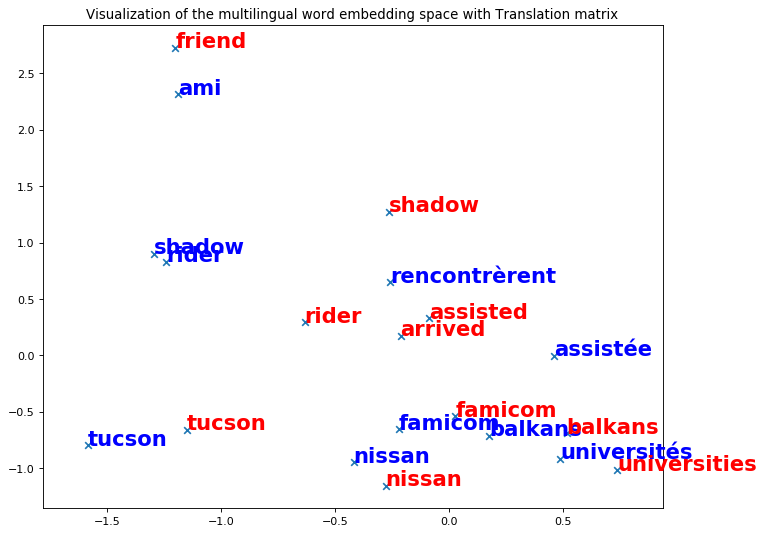

In [257]:
import random
src_words = random.sample(list(src_word2id.keys()), 10)
#src_words = ['bateau', 'maison', 'argent', 'ordinateur', 'dieu']
tgt_words = []
for i in range(0,len(src_words)):
    top1, top5 = prediction(W_GD, src_words[i], k=5) #top 1: english word (target)
    tgt_words.append(top1[0])

# assert words in dictionaries
for sw in src_words:
    assert sw in src_word2id, '"%s" not in source dictionary' % sw
for tw in tgt_words:
    assert tw in tgt_word2id, '"%s" not in target dictionary' % sw

plot_similar_word(src_words, src_word2id, src_embeddings, tgt_words, tgt_word2id, tgt_embeddings, pca)



In [258]:
tgt_words

['arrived',
 'tucson',
 'balkans',
 'assisted',
 'nissan',
 'rider',
 'famicom',
 'friend',
 'shadow',
 'universities']

In [259]:
src_words

['rencontrèrent',
 'tucson',
 'balkans',
 'assistée',
 'nissan',
 'rider',
 'famicom',
 'ami',
 'shadow',
 'universités']

In [235]:
top1, top5 = prediction(W_GD, "oreiller", k=5)
print("Top 1 translation for '' is :", top1)
print("Top 5 translations for 'bateau' are :", top5)

Top 1 translation for '' is : ['ears']
Top 5 translations for 'bateau' are : ['ears', 'ear', 'eyes', 'lips', 'nose']
